In [1]:
from gtm import *

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GTM Package including GTM and the plot functions
from gtm import *
# Sample Copulas Package
import pyvinecopulib as pv
import numpy as np
# Other Stuff
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Sample Data

In [3]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [4]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_53100/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_53100/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_53100/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

In [5]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [6]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_53100/2452348847.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_53100/2452348847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_53100/2452348847.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

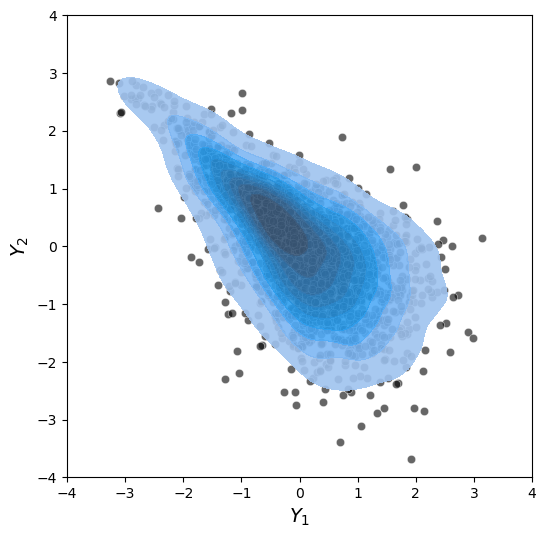

In [7]:
_ = plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

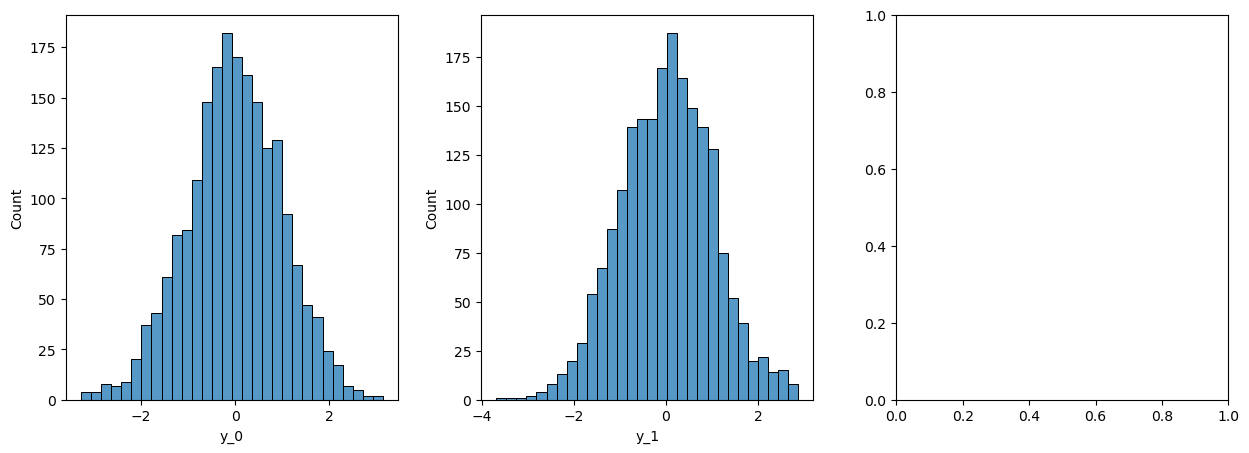

In [8]:
_ = plot_marginals(simulated_data_train)

In [9]:
class Copula_2D_Dataset(Dataset):
    def __init__(self, data):
        
        # First Dimension (N) needs to be the samples
        # Second Dimension (D) is the dimensionality of the data
        self.data = data
    
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
# Create dataset and DataLoader
dataset_train = Copula_2D_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Copula_2D_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

In [10]:
# Here you can see that we load the full data, so not batches
# Model is just implemented with dataloaders because that is eeded for huge datasets in bioinformatics
data_iter = iter(dataloader_train)
sample = next(data_iter)
sample.size()

torch.Size([2000, 2])

### 2. Define Model

In [11]:
model = GTM(
    transformation_spline_range=list([[-10], [10]]), 
    degree_decorrelation=40,
    degree_transformations=15,
    num_decorr_layers=3,
    num_trans_layers=1,
    number_variables=2,
    device="cpu") 

### 3. Hyperparameter Tune and Train Model

In [12]:
study = model.hyperparameter_tune_penalties( 
                                train_dataloader=dataloader_train, 
                                validate_dataloader=dataloader_validate, 
                                penvalueridge = [0], #["sample"],
                                penfirstridge = ["sample"],
                                pensecondridge = ["sample"],
                                ctm_pensecondridge = [0], #["sample"],
                                lambda_penalty_params = [0], #["sample"],
                                train_covariates=False, 
                                validate_covariates=False, 
                                adaptive_lasso_weights_matrix = False,
                                learning_rate=1, 
                                iterations=1000, 
                                patience=5, 
                                min_delta=1e-7, 
                                optimizer='LBFGS', 
                                lambda_penalty_mode="square", 
                                objective_type="negloglik", 
                                seperate_copula_training=False,
                                max_batches_per_iter=False,
                                tuning_mode="optuna",
                                cross_validation_folds=False,
                                random_state_KFold=42,
                                device=None,
                                pretrained_transformation_layer=False,
                                n_trials=20,
                                temp_folder=".", 
                                study_name=None)
    
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            study.best_params["penfirstridge"],
                            study.best_params["pensecondridge"],
                            0 #study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params=False

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-22 16:48:31,637] A new study created in RDB with name: no-name-36f957c6-fb86-45bd-b997-087f379f5503


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 8.590370271564678   pensecondridge_opt: 21.95796901093608   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  3%|▎         | 32/1000 [00:00<00:24, 40.02it/s]
[I 2025-05-22 16:48:33,063] Trial 0 finished with value: -2.503518581390381 and parameters: {'penfirstridge': 8.590370271564678, 'pensecondridge': 21.95796901093608}. Best is trial 0 with value: -2.503518581390381.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 24.763369616591298   pensecondridge_opt: 2.2234630263142217   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  3%|▎         | 29/1000 [00:00<00:23, 40.49it/s]
[I 2025-05-22 16:48:33,839] Trial 1 finished with value: -2.51566481590271 and parameters: {'penfirstridge': 24.763369616591298, 'pensecondridge': 2.2234630263142217}. Best is trial 0 with value: -2.503518581390381.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 29.576424216798095   pensecondridge_opt: 18.62417247319962   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  4%|▍         | 42/1000 [00:01<00:23, 39.94it/s]
[I 2025-05-22 16:48:34,923] Trial 2 finished with value: -2.515228509902954 and parameters: {'penfirstridge': 29.576424216798095, 'pensecondridge': 18.62417247319962}. Best is trial 0 with value: -2.503518581390381.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 29.96288098616418   pensecondridge_opt: 16.756789216227673   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  5%|▍         | 48/1000 [00:01<00:24, 38.47it/s]
[I 2025-05-22 16:48:36,203] Trial 3 finished with value: -2.5136823654174805 and parameters: {'penfirstridge': 29.96288098616418, 'pensecondridge': 16.756789216227673}. Best is trial 0 with value: -2.503518581390381.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 4.7283027030832265   pensecondridge_opt: 4.012246922906097   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  6%|▌         | 60/1000 [00:01<00:25, 37.23it/s]
[I 2025-05-22 16:48:37,847] Trial 4 finished with value: -2.482879400253296 and parameters: {'penfirstridge': 4.7283027030832265, 'pensecondridge': 4.012246922906097}. Best is trial 4 with value: -2.482879400253296.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 5.504946262668944   pensecondridge_opt: 12.795279357161572   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  8%|▊         | 81/1000 [00:02<00:23, 39.83it/s]
[I 2025-05-22 16:48:39,914] Trial 5 finished with value: -2.4827988147735596 and parameters: {'penfirstridge': 5.504946262668944, 'pensecondridge': 12.795279357161572}. Best is trial 5 with value: -2.4827988147735596.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.789829945479707   pensecondridge_opt: 11.455286377979583   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  3%|▎         | 33/1000 [00:00<00:23, 41.89it/s]
[I 2025-05-22 16:48:40,733] Trial 6 finished with value: -2.4936022758483887 and parameters: {'penfirstridge': 2.789829945479707, 'pensecondridge': 11.455286377979583}. Best is trial 5 with value: -2.4827988147735596.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 12.095225751010451   pensecondridge_opt: 8.454326847411394   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  6%|▌         | 59/1000 [00:01<00:23, 40.61it/s]
[I 2025-05-22 16:48:42,241] Trial 7 finished with value: -2.4865267276763916 and parameters: {'penfirstridge': 12.095225751010451, 'pensecondridge': 8.454326847411394}. Best is trial 5 with value: -2.4827988147735596.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 6.5085953775151175   pensecondridge_opt: 19.060570895557294   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  7%|▋         | 73/1000 [00:01<00:22, 40.35it/s]
[I 2025-05-22 16:48:44,089] Trial 8 finished with value: -2.485582113265991 and parameters: {'penfirstridge': 6.5085953775151175, 'pensecondridge': 19.060570895557294}. Best is trial 5 with value: -2.4827988147735596.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 11.505498425979326   pensecondridge_opt: 14.123370586683064   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  3%|▎         | 33/1000 [00:00<00:26, 36.08it/s]
[I 2025-05-22 16:48:45,039] Trial 9 finished with value: -2.5006449222564697 and parameters: {'penfirstridge': 11.505498425979326, 'pensecondridge': 14.123370586683064}. Best is trial 5 with value: -2.4827988147735596.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 13.71915902984933   pensecondridge_opt: 27.39209258972536   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  3%|▎         | 31/1000 [00:00<00:22, 42.66it/s]
[I 2025-05-22 16:48:45,801] Trial 10 finished with value: -2.5115787982940674 and parameters: {'penfirstridge': 13.71915902984933, 'pensecondridge': 27.39209258972536}. Best is trial 5 with value: -2.4827988147735596.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 10.783501518156168   pensecondridge_opt: 0.8954875961356557   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  4%|▍         | 42/1000 [00:01<00:23, 40.18it/s]
[I 2025-05-22 16:48:46,878] Trial 11 finished with value: -2.494403839111328 and parameters: {'penfirstridge': 10.783501518156168, 'pensecondridge': 0.8954875961356557}. Best is trial 5 with value: -2.4827988147735596.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 3.621475154254817   pensecondridge_opt: 3.7364699236444325   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 10%|▉         | 96/1000 [00:02<00:22, 39.65it/s]
[I 2025-05-22 16:48:49,333] Trial 12 finished with value: -2.4790358543395996 and parameters: {'penfirstridge': 3.621475154254817, 'pensecondridge': 3.7364699236444325}. Best is trial 12 with value: -2.4790358543395996.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.3402883976165394   pensecondridge_opt: 1.6786856678780762   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  5%|▍         | 49/1000 [00:01<00:24, 39.03it/s]
[I 2025-05-22 16:48:50,624] Trial 13 finished with value: -2.4782919883728027 and parameters: {'penfirstridge': 2.3402883976165394, 'pensecondridge': 1.6786856678780762}. Best is trial 13 with value: -2.4782919883728027.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 3.359455432129397   pensecondridge_opt: 0.3434991147189965   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  3%|▎         | 26/1000 [00:00<00:28, 34.60it/s]
[I 2025-05-22 16:48:51,418] Trial 14 finished with value: -2.4920732975006104 and parameters: {'penfirstridge': 3.359455432129397, 'pensecondridge': 0.3434991147189965}. Best is trial 13 with value: -2.4782919883728027.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.3000682778602597   pensecondridge_opt: 9.324143272562917   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  2%|▏         | 21/1000 [00:00<00:26, 36.32it/s]
[I 2025-05-22 16:48:52,046] Trial 15 finished with value: -2.5030813217163086 and parameters: {'penfirstridge': 0.3000682778602597, 'pensecondridge': 9.324143272562917}. Best is trial 13 with value: -2.4782919883728027.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 17.30441730550626   pensecondridge_opt: 0.5484203616133025   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  4%|▍         | 39/1000 [00:00<00:23, 41.40it/s]
[I 2025-05-22 16:48:53,026] Trial 16 finished with value: -2.496903419494629 and parameters: {'penfirstridge': 17.30441730550626, 'pensecondridge': 0.5484203616133025}. Best is trial 13 with value: -2.4782919883728027.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.40649258571089275   pensecondridge_opt: 3.9181773823268427   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  6%|▌         | 57/1000 [00:01<00:23, 40.90it/s]
[I 2025-05-22 16:48:54,453] Trial 17 finished with value: -2.480550527572632 and parameters: {'penfirstridge': 0.40649258571089275, 'pensecondridge': 3.9181773823268427}. Best is trial 13 with value: -2.4782919883728027.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 20.587672540509594   pensecondridge_opt: 9.076547063364934   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  4%|▍         | 41/1000 [00:01<00:23, 40.92it/s]
[I 2025-05-22 16:48:55,488] Trial 18 finished with value: -2.5041794776916504 and parameters: {'penfirstridge': 20.587672540509594, 'pensecondridge': 9.076547063364934}. Best is trial 13 with value: -2.4782919883728027.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 0.09440253518653297   pensecondridge_opt: 18.914969063742753   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  6%|▋         | 63/1000 [00:01<00:22, 41.77it/s]
[I 2025-05-22 16:48:57,032] Trial 19 finished with value: -2.4831199645996094 and parameters: {'penfirstridge': 0.09440253518653297, 'pensecondridge': 18.914969063742753}. Best is trial 13 with value: -2.4782919883728027.


hyperparameter_tuning done


In [13]:
# pretrain the marginal transformations
_ = model.pretrain_tranformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_params=penalty_params)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py:296: UserWarning: Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.
  warnings.warn("Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.")
 28%|██▊       | 281/1000 [00:03<00:08, 88.59it/s] 


In [14]:
# train the joint model
_ = model.__train__(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_params=penalty_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, lambda_penalty_params=lambda_penalty_params, 
                max_batches_per_iter=False)

  3%|▎         | 29/1000 [00:00<00:25, 38.61it/s]


### 4. Compare Fit to Benchmarks

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)  # 0 to do mean across dim 0 not globally
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.0119
KLD Gaussian Train Data:  0.094
KLD Copula   Train Data:  -0.0004
KLD GTM      Test  Data:  0.0313
KLD Gaussian Test  Data:  0.1058
KLD Copula   Test  Data:  0.0004


KLD GTM      Train Data:  0.0113
KLD Gaussian Train Data:  0.1057
KLD Copula   Train Data:  -0.0005
KLD GTM      Test  Data:  0.0117
KLD Gaussian Test  Data:  0.1143
KLD Copula   Test  Data:  0.0009

### 5. Evaluate and Plot GTM Results

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(2000)

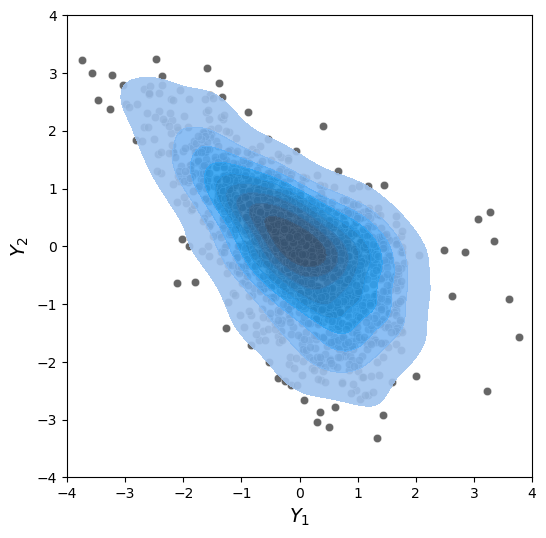

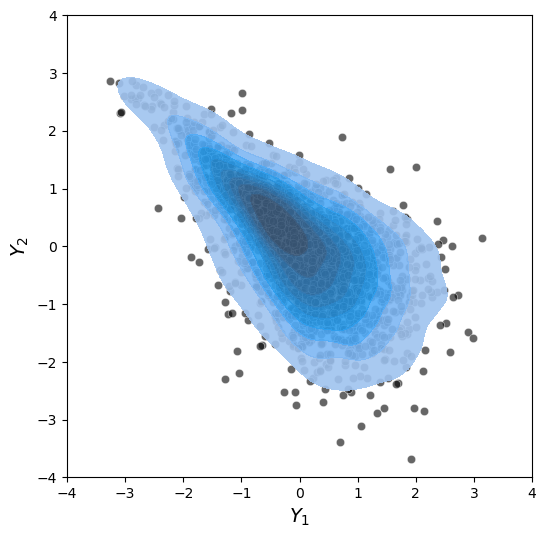

In [19]:
_ = plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
_ = plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [20]:
synthetic_samples = model.sample(2000)
p_matrix = model.compute_precision_matrix(synthetic_samples)

In [21]:
conditional_correlation_matrix_train = model.compute_correlation_matrix(synthetic_samples)
conditional_correlation = conditional_correlation_matrix_train[:,0,1]

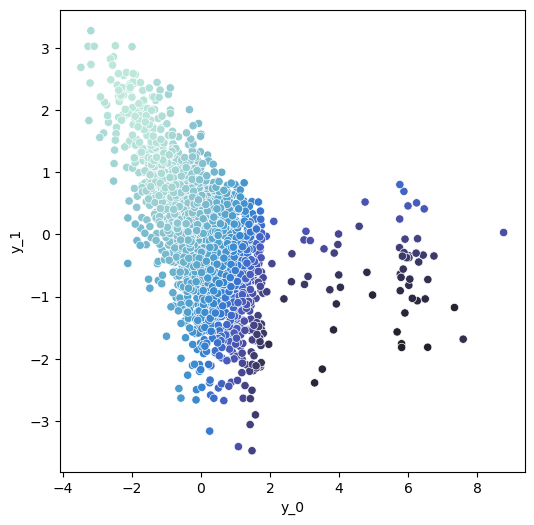

In [22]:
_ = plot_metric_scatter(data=synthetic_samples,metric=conditional_correlation)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, spline_num],


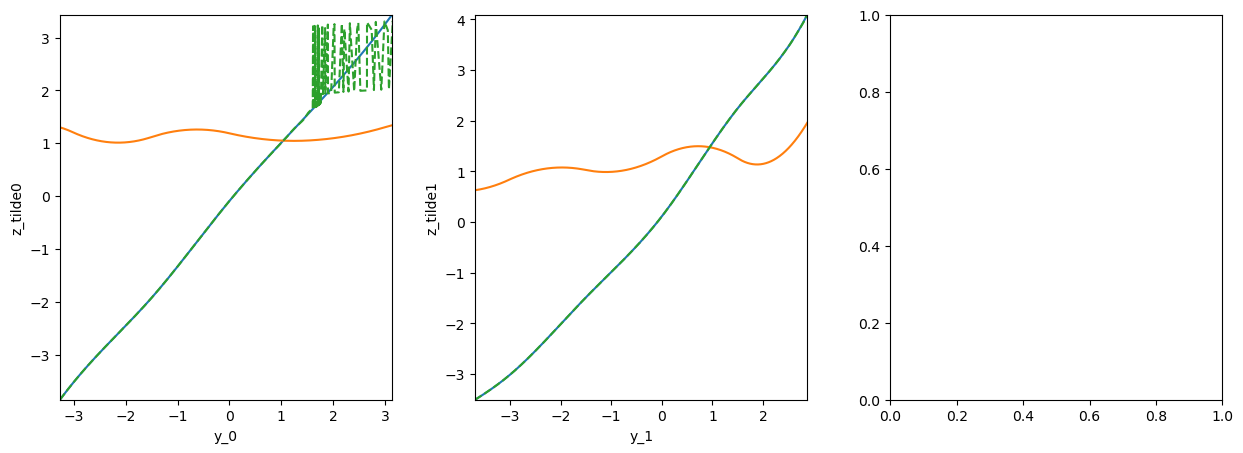

In [23]:
_ = plot_splines(model.transformation,simulated_data_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


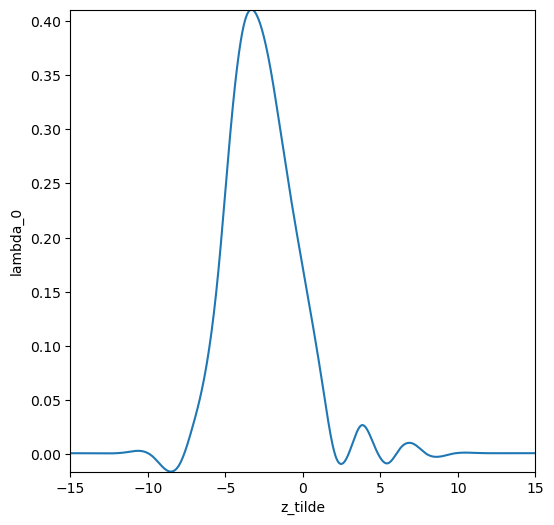

In [24]:
_ = plot_splines(model.decorrelation_layers[0],simulated_data_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


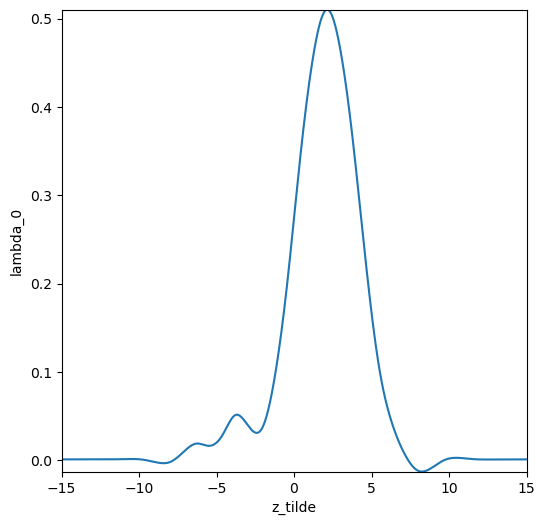

In [25]:
_ = plot_splines(model.decorrelation_layers[1],simulated_data_train)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:138: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


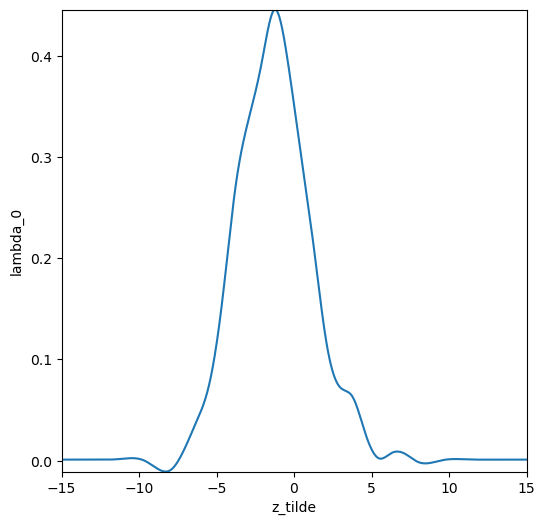

In [26]:
_ = plot_splines(model.decorrelation_layers[2],simulated_data_train)